In [1]:
import cv2
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import random

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

<ipython-input-2-2c2ed39229d7>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unlabeld_index = np.ones(y_train.shape, np.bool)


In [3]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
-0.0
-0.0


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
NUM_CLASSES = 10
INPUT_SHAPE = x_train.shape[1:]

In [6]:
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [7]:
def plot_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [8]:
def block(input, filters, pool_size):
  x = Conv2D(
        filters=filters,
        kernel_size=(3, 3),
        activation='relu',
    )(input)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPool2D(
      pool_size=pool_size
  )(x)
  x = Dropout(rate=0.2)(x)
  return x

In [9]:
def build_back_model(input_shape=INPUT_SHAPE):
    input = Input(shape=(input_shape))

    # Block 1
    x = block(input, 32, (3, 3))

    # Block 2
    x = block(x, 64, (2, 2))

    # Block 3
    x = block(x, 128, (2, 2))

    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dropout(rate=0.2)(x)

    model = Model(inputs=input, outputs=output, name='back_model')
    return model

In [10]:
temp = build_back_model()
temp.summary()

Model: "back_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          1

In [11]:
def build_model(back_model, units, learning_rate=0.001):
  model = Sequential()
  model.add(back_model)
  model.add(Dense(units=units, activation='softmax'))

  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss=CategoricalCrossentropy(),
      metrics=['accuracy']
  )
  model.summary()
  return model


---

## 1.

---



In [12]:
back_model = build_back_model()
model = build_model(back_model, 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 back_model (Functional)     (None, 1024)              230336    
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


In [13]:
EPOCHS = 50
BATCH_SIZE = 32

In [14]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test)
)

Epoch 1/50
7/7 [==============================] - 4s 464ms/step - loss: 2.8444 - accuracy: 0.1600 - val_loss: 2.2959 - val_accuracy: 0.1001
Epoch 2/50
7/7 [==============================] - 2s 405ms/step - loss: 2.2742 - accuracy: 0.2600 - val_loss: 2.2921 - val_accuracy: 0.1494
Epoch 3/50
7/7 [==============================] - 2s 403ms/step - loss: 1.8984 - accuracy: 0.3700 - val_loss: 2.2997 - val_accuracy: 0.1103
Epoch 4/50
7/7 [==============================] - 3s 435ms/step - loss: 1.9842 - accuracy: 0.3450 - val_loss: 2.3115 - val_accuracy: 0.1048
Epoch 5/50
7/7 [==============================] - 3s 422ms/step - loss: 1.8378 - accuracy: 0.3700 - val_loss: 2.3271 - val_accuracy: 0.1032
Epoch 6/50
7/7 [==============================] - 2s 407ms/step - loss: 1.6092 - accuracy: 0.4500 - val_loss: 2.3415 - val_accuracy: 0.1124
Epoch 7/50
7/7 [==============================] - 3s 499ms/step - loss: 1.4964 - accuracy: 0.5100 - val_loss: 2.3747 - val_accuracy: 0.0996
Epoch 8/50
7/7 [====

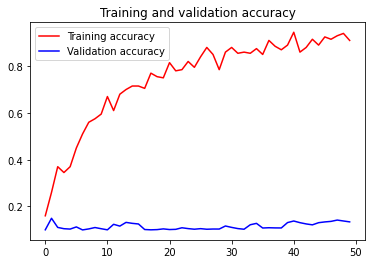

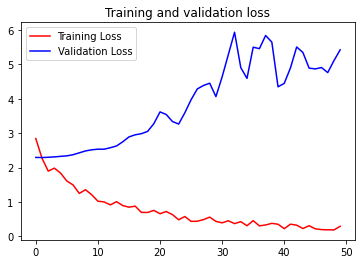

In [15]:
plot_results(history)


---

## 2.

---



In [16]:
x_train_rotate = np.zeros_like(x_unlabeld)
y_train_rotate = np.zeros((x_unlabeld.shape[0], 4))

labels = [0, 1, 2, 3]
degrees = [0, 90, 180, 270]

In [17]:
def rotate(x, deg):
  return 0 if deg == 0 \
  else np.rot90(x) if deg == 90 \
  else np.rot90(np.rot90(x)) if deg == 180 \
  else np.rot90(np.rot90(np.rot90(x)))

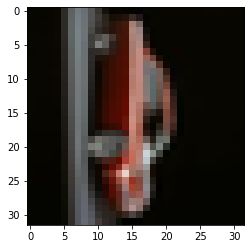

[0. 0. 0. 1.] 



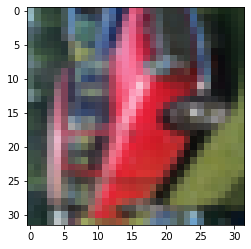

[0. 1. 0. 0.] 



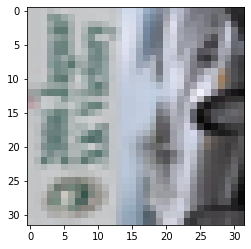

[0. 1. 0. 0.] 



In [39]:
for i in range(x_train_rotate.shape[0]):
  label = random.choices(labels, weights=[1, 3, 3, 3], k=1)[0]
  deg = degrees[label]
  rotated_image = rotate(x_unlabeld[i], deg)

  x_train_rotate[i] = rotated_image
  y_train_rotate[i] = to_categorical(label, num_classes=4)

for i in range(3):
    plt.imshow(x_train_rotate[i], interpolation='nearest')
    plt.show()
    print(y_train_rotate[i], '\n')

In [19]:
back_model = build_back_model()
model_1 = build_model(back_model, 4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 back_model (Functional)     (None, 1024)              230336    
                                                                 
 dense_4 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 234,436
Trainable params: 231,940
Non-trainable params: 2,496
_________________________________________________________________


In [20]:
history = model_1.fit(
    x_train_rotate,
    y_train_rotate,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS - 10,
    validation_split=0.2,
)

Epoch 1/40
1245/1245 [==============================] - 37s 29ms/step - loss: 0.9783 - accuracy: 0.5594 - val_loss: 0.7807 - val_accuracy: 0.6524
Epoch 2/40
1245/1245 [==============================] - 36s 29ms/step - loss: 0.7761 - accuracy: 0.6458 - val_loss: 0.6825 - val_accuracy: 0.6953
Epoch 3/40
1245/1245 [==============================] - 36s 29ms/step - loss: 0.7185 - accuracy: 0.6767 - val_loss: 0.6404 - val_accuracy: 0.7144
Epoch 4/40
1245/1245 [==============================] - 37s 30ms/step - loss: 0.6824 - accuracy: 0.6979 - val_loss: 0.6541 - val_accuracy: 0.7073
Epoch 5/40
1245/1245 [==============================] - 36s 29ms/step - loss: 0.6524 - accuracy: 0.7158 - val_loss: 0.6549 - val_accuracy: 0.7088
Epoch 6/40
1245/1245 [==============================] - 36s 29ms/step - loss: 0.6291 - accuracy: 0.7262 - val_loss: 0.6180 - val_accuracy: 0.7270
Epoch 7/40
1245/1245 [==============================] - 36s 29ms/step - loss: 0.6120 - accuracy: 0.7349 - val_loss: 0.5666 -

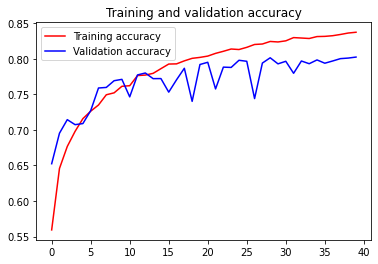

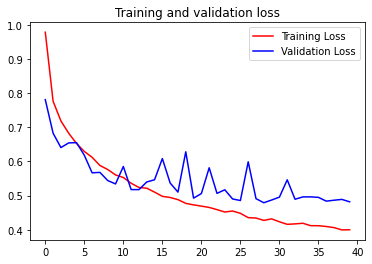

In [21]:
plot_results(history)

In [40]:
model_2 = build_model(model_1.layers[0], 10, learning_rate=0.00005)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 back_model (Functional)     (None, 1024)              230336    
                                                                 
 dense_10 (Dense)            (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


In [42]:
history = model_2.fit(
  x_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS + 10,
  validation_data=(x_test, y_test),
)

Epoch 1/60
7/7 [==============================] - 4s 452ms/step - loss: 2.4640 - accuracy: 0.0900 - val_loss: 2.4325 - val_accuracy: 0.0848
Epoch 2/60
7/7 [==============================] - 3s 415ms/step - loss: 2.4302 - accuracy: 0.0700 - val_loss: 2.4299 - val_accuracy: 0.0815
Epoch 3/60
7/7 [==============================] - 3s 412ms/step - loss: 2.3651 - accuracy: 0.0850 - val_loss: 2.4275 - val_accuracy: 0.0784
Epoch 4/60
7/7 [==============================] - 2s 412ms/step - loss: 2.3882 - accuracy: 0.0850 - val_loss: 2.4255 - val_accuracy: 0.0783
Epoch 5/60
7/7 [==============================] - 2s 410ms/step - loss: 2.3752 - accuracy: 0.1000 - val_loss: 2.4238 - val_accuracy: 0.0779
Epoch 6/60
7/7 [==============================] - 2s 405ms/step - loss: 2.3589 - accuracy: 0.0900 - val_loss: 2.4244 - val_accuracy: 0.0780
Epoch 7/60
7/7 [==============================] - 2s 406ms/step - loss: 2.3504 - accuracy: 0.1100 - val_loss: 2.4222 - val_accuracy: 0.0810
Epoch 8/60
7/7 [====

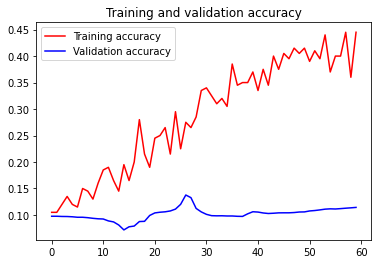

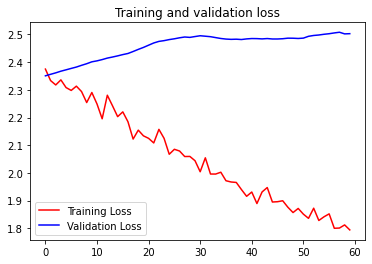

In [25]:
plot_results(history)

In [26]:
loss, acc = model_2.evaluate(x_test, y_test)
print(f"test loss: {loss}, test accuracy: {acc}")

313/313 [==============================] - 3s 8ms/step - loss: 2.5027 - accuracy: 0.1143
test loss: 2.5027029514312744, test accuracy: 0.11429999768733978



---

## 3.

---



In [27]:
def build_two_out_model():
  back_model = Sequential()
  back_model.add(build_back_model())

  classifier = Dense(
      units=10,
      activation='softmax',
      name='classifier'
  )(back_model.outputs[0])
  rotator = Dense(
      units=4,
      activation='softmax',
      name='rotator'
  )(back_model.outputs[0])

  two_out_model = Model(
      inputs=back_model.inputs,
      outputs=[classifier, rotator]
  )
  return two_out_model

In [28]:
temp = build_two_out_model()
temp.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 back_model_input (InputLayer)  [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 back_model (Functional)        (None, 1024)         230336      ['back_model_input[0][0]']       
                                                                                                  
 classifier (Dense)             (None, 10)           10250       ['back_model[0][0]']             
                                                                                                  
 rotator (Dense)                (None, 4)            4100        ['back_model[0][0]']             
                                                                                              

In [29]:
y_train_class = np.concatenate((
    y_train, 
    np.zeros((x_train_rotate.shape[0], 10))), 
    axis=0
)
y_train_rot = np.concatenate((
    np.zeros((y_train.shape[0], 4)), y_train_rotate), 
    axis=0
)

x_train_all = np.concatenate((
    x_train, x_train_rotate), 
    axis=0
)
y_train_all = [y_train_class, y_train_rot]

In [30]:
def fit_two_out_model(classifier, rotator):
  two_out_model = build_two_out_model()
  two_out_model.compile(
      optimizer=Adam(learning_rate=0.001),
      metrics=['accuracy'],
      loss_weights={
          'classifier': classifier,
          'rotator': rotator
      },
      loss=CategoricalCrossentropy(),
  )
  history = two_out_model.fit(
      x_train_all,
      y_train_all,
      batch_size=BATCH_SIZE,
      epochs=15,
      validation_data=(x_test, {'classifier': y_test})
  )
  return history

In [31]:
def plot(history, section):
  plt.plot(history.history[section])
  if section != 'rotator_loss' and section != 'rotator_accuracy':
      plt.plot(history.history['val_' + section])
  plt.title(section)
  plt.ylabel(section)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  print()

In [32]:
def plot_all_results(history):
  plot(history, 'rotator_accuracy')
  plot(history, 'rotator_loss')
  plot(history, 'classifier_accuracy')
  plot(history, 'classifier_loss')
  plot(history, 'loss')

In [33]:
two_out_model_1_history = fit_two_out_model(10, 1)

Epoch 1/15
1563/1563 [==============================] - 48s 30ms/step - loss: 1.3883 - classifier_loss: 0.0129 - rotator_loss: 1.2592 - classifier_accuracy: 0.1027 - rotator_accuracy: 0.4182 - val_loss: 64.2144 - val_classifier_loss: 6.4214 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0999 - val_rotator_accuracy: 0.0000e+00
Epoch 2/15
1563/1563 [==============================] - 46s 29ms/step - loss: 1.6874 - classifier_loss: 0.0157 - rotator_loss: 1.5308 - classifier_accuracy: 0.1025 - rotator_accuracy: 0.3669 - val_loss: 117.1969 - val_classifier_loss: 11.7197 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1000 - val_rotator_accuracy: 0.0000e+00
Epoch 3/15
1563/1563 [==============================] - 45s 29ms/step - loss: 1.8691 - classifier_loss: 0.0150 - rotator_loss: 1.7191 - classifier_accuracy: 0.1016 - rotator_accuracy: 0.3436 - val_loss: 596.9670 - val_classifier_loss: 59.6967 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1000 - val_ro

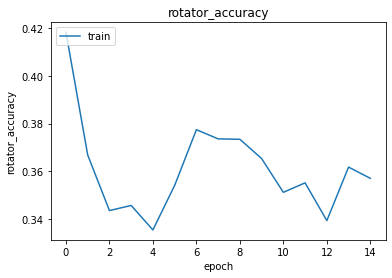

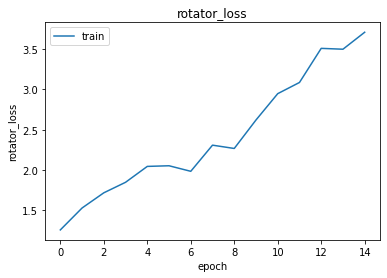

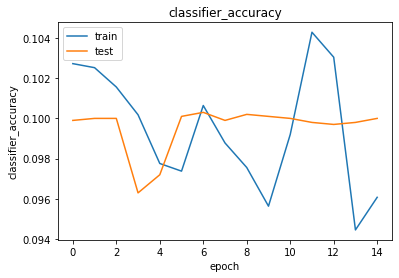

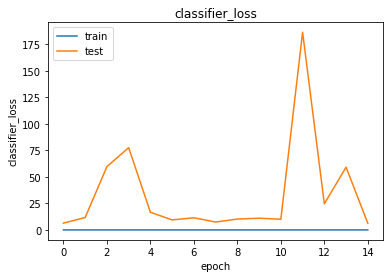

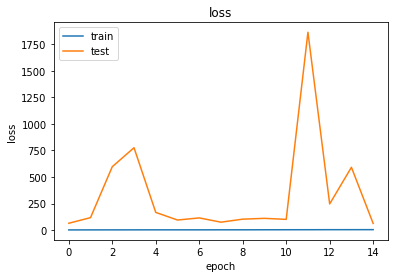

In [34]:
plot_all_results(two_out_model_1_history)

In [35]:
two_out_model_2_history = fit_two_out_model(1, 10)

Epoch 1/15
1563/1563 [==============================] - 48s 30ms/step - loss: 10.6002 - classifier_loss: 0.0118 - rotator_loss: 1.0588 - classifier_accuracy: 0.1199 - rotator_accuracy: 0.5259 - val_loss: 6.9665 - val_classifier_loss: 6.9665 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0998 - val_rotator_accuracy: 0.0000e+00
Epoch 2/15
1563/1563 [==============================] - 47s 30ms/step - loss: 11.6719 - classifier_loss: 0.0142 - rotator_loss: 1.1658 - classifier_accuracy: 0.1109 - rotator_accuracy: 0.4832 - val_loss: 5.2855 - val_classifier_loss: 5.2855 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.0997 - val_rotator_accuracy: 0.0000e+00
Epoch 3/15
1563/1563 [==============================] - 46s 29ms/step - loss: 13.9963 - classifier_loss: 0.0124 - rotator_loss: 1.3984 - classifier_accuracy: 0.1055 - rotator_accuracy: 0.4249 - val_loss: 32.4495 - val_classifier_loss: 32.4495 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1020 - val_rota

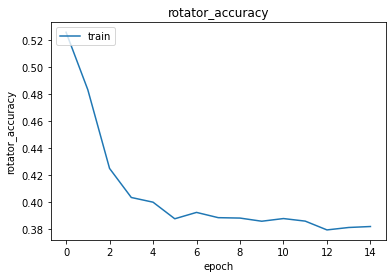

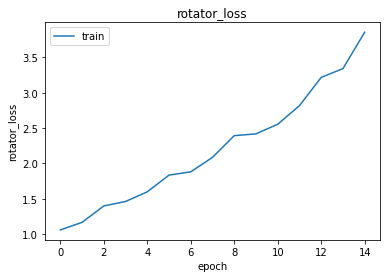

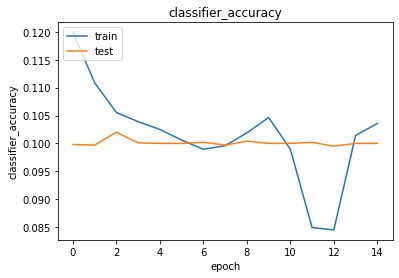

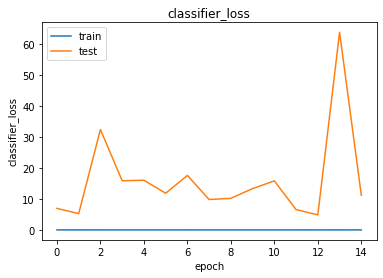

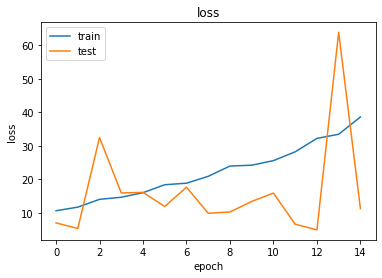

In [36]:
plot_all_results(two_out_model_2_history)

In [37]:
two_out_model_3_history = fit_two_out_model(1, 1)

Epoch 1/15
1563/1563 [==============================] - 48s 30ms/step - loss: 1.1960 - classifier_loss: 0.0140 - rotator_loss: 1.1819 - classifier_accuracy: 0.1088 - rotator_accuracy: 0.4586 - val_loss: 6.9434 - val_classifier_loss: 6.9434 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1000 - val_rotator_accuracy: 0.0000e+00
Epoch 2/15
1563/1563 [==============================] - 47s 30ms/step - loss: 1.3534 - classifier_loss: 0.0140 - rotator_loss: 1.3394 - classifier_accuracy: 0.1040 - rotator_accuracy: 0.4015 - val_loss: 6.2603 - val_classifier_loss: 6.2603 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1002 - val_rotator_accuracy: 0.0000e+00
Epoch 3/15
1563/1563 [==============================] - 46s 30ms/step - loss: 1.7327 - classifier_loss: 0.0144 - rotator_loss: 1.7183 - classifier_accuracy: 0.1016 - rotator_accuracy: 0.3591 - val_loss: 16.7235 - val_classifier_loss: 16.7235 - val_rotator_loss: 0.0000e+00 - val_classifier_accuracy: 0.1001 - val_rotator

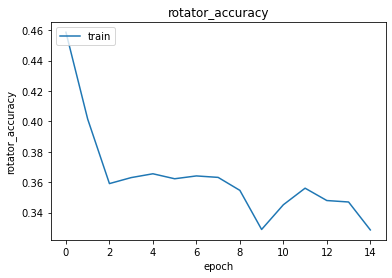

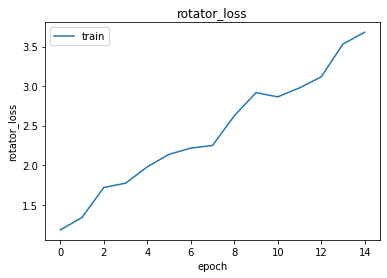

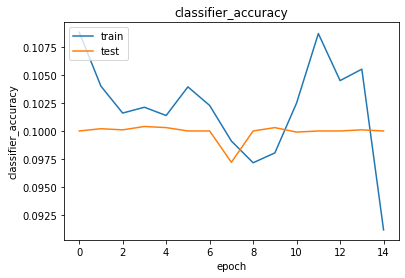

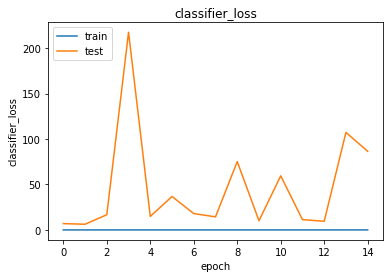

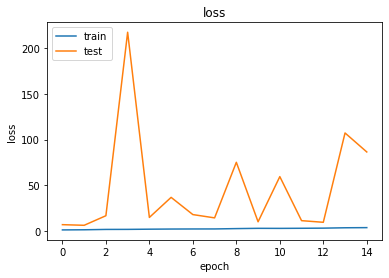

In [38]:
plot_all_results(two_out_model_3_history)